# Competitors

30 June, 2024

@roman

Code to find neighbors of a given competitor for each property.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from tqdm import tqdm
import h3
import os

from scipy.spatial import KDTree
import scipy.sparse as sp
from scipy import io
from sklearn.cluster import MiniBatchKMeans, SpectralClustering, HDBSCAN
from INEGIpy import MarcoGeoestadistico

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Settings
# show 100 columns in pandas
pd.set_option('display.max_columns', 100)
geo_framework = MarcoGeoestadistico()

---
# Data

## Properties

In [3]:
# read parquet
gdf_properties = pd.read_parquet("../../data/interim/cleaned_data_s4.parquet")

# cluster for trails
CLUSTERS_TRIALS = [7, 19, 10] # qro, cancun, cdmx

# subset
gdf_properties = gdf_properties[gdf_properties['city_cluster'].isin(CLUSTERS_TRIALS)]

# to geopandas
gdf_properties = gpd.GeoDataFrame(
    gdf_properties,
    geometry=gpd.points_from_xy(gdf_properties['longitude'], gdf_properties['latitude']),
    crs="EPSG:4326"
    )

# change crs to 6372
gdf_properties = gdf_properties.to_crs("EPSG:6372")

gdf_properties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 371848 entries, 50 to 1909958
Data columns (total 54 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   half_bathrooms                      371848 non-null  uint8         
 1   full_bathrooms                      371848 non-null  uint8         
 2   property_class_more_common_in_area  371848 non-null  string        
 3   neighborhood                        371847 non-null  string        
 4   constructor                         371644 non-null  string        
 5   zip_code                            371848 non-null  uint32        
 6   age_in_months                       371848 non-null  uint8         
 7   parking_lots                        371848 non-null  uint8         
 8   valuation_date                      371848 non-null  datetime64[ns]
 9   potable_water_service_id            246360 non-null  float64       
 10  lig

In [4]:
# print property_id unique
print(gdf_properties['property_id'].nunique())
print(gdf_properties['observation_id'].nunique())

361545
371848


## Cities

In [5]:
# read parquet
gdf_cities = gpd.read_parquet("../../data/misc/cities.parquet")

# change crs to 6372
gdf_cities = gdf_cities.to_crs("EPSG:6372")

# look
gdf_cities

geometry  cluster  \
0    POLYGON ((3766192.137 1038920.719, 3766072.241...        0   
1    POLYGON ((2106201.674 1838908.292, 2106105.496...        1   
2    POLYGON ((2083964.935 2167068.796, 2083854.591...        2   
3    POLYGON ((3695976.760 913468.113, 3695883.500 ...        3   
4    POLYGON ((2691489.214 1478562.321, 2691414.834...        4   
..                                                 ...      ...   
109  POLYGON ((2809075.793 1188762.402, 2808986.206...      109   
110  POLYGON ((2652237.387 1032197.642, 2652132.900...      110   
111  POLYGON ((2608508.314 1013348.771, 2608407.574...      111   
112  POLYGON ((2401691.811 1520986.348, 2401617.754...      112   
113  POLYGON ((3546401.722 351695.680, 3546300.455 ...      113   

     total_properties  
0               49294  
1               41078  
2               49914  
3                4945  
4              224732  
..                ...  
109              1570  
110              1158  
111              1402  
112              1189  
113              4580  

[114 rows x 3 columns]

In [6]:
# see map
gdf_cities.explore(tiles="cartodbpositron")

## Wrangle

In [7]:
# wrangle
gdf_properties = (
    gdf_properties
    # new vars
    .assign(
        property_type=lambda x: np.where(x['property_type_id'].le(3), 'house', 'apartment'),
        longitude=lambda x: x["geometry"].x,
        latitude=lambda x: x["geometry"].y,
        parking_lots=lambda x: x["parking_lots"].fillna(0),
        price_per_sqm=lambda x: x["price"] / x["saleable_area"],
        log_price_per_sqm=lambda x: np.log(x["price_per_sqm"]),
    )
    .reset_index(drop=True)
    # categorize variables for comparisson
    .assign(
        bedrooms_cat=lambda x: np.select(
            [
                x["bedrooms"].le(1),
                x["bedrooms"].le(2),
                x["bedrooms"].le(3),
                x["bedrooms"].gt(3),
            ],
            [
                1, 2, 3, 4
            ],
            default=0
        ),
        full_bathrooms_cat=lambda x: np.select(
            [
                x["full_bathrooms"].le(1),
                x["full_bathrooms"].le(2),
                x["full_bathrooms"].le(3),
                x["full_bathrooms"].gt(3),
            ],
            [
                1, 2, 3, 4
            ],
            default=0
        ),
        max_total_levels=lambda x:
            x[['level', 'total_levels']].max(axis=1),
        max_total_levels_recat=lambda x: np.select(
            [
                x["max_total_levels"].le(1),
                x["max_total_levels"].le(5),
                x["max_total_levels"].le(15),
                x["max_total_levels"].gt(15),
            ],
            [
                1, 2, 3, 4
            ],
            default=0
        ),
        elevator_service_id_cat=lambda x:
            np.where(x['elevator_service_id'].eq(1), 1, 0),
        parking_lots_cat=lambda x: np.select(
            [
                x["parking_lots"].le(0),
                x["parking_lots"].le(1),
                x["parking_lots"].le(2),
                x["parking_lots"].gt(2),
            ],
            [
                0, 1, 2, 3
            ],
            default=0
        ),
    )
)   

## Mini EDA

In [8]:
# see cat vars description
(
    gdf_properties
    .filter(like="_cat")
    .apply(pd.Series.value_counts)
    .div(gdf_properties.shape[0])
)

bedrooms_cat  full_bathrooms_cat  elevator_service_id_cat  parking_lots_cat
0           NaN                 NaN                 0.924367          0.172372
1      0.053863            0.575988                 0.075633          0.576620
2      0.568673            0.296264                      NaN          0.215706
3      0.324998            0.086573                      NaN          0.035302
4      0.052465            0.041175                      NaN               NaN

In [9]:
# see how many properties didnt join
gdf_properties["city_cluster"].isna().sum()

0

In [10]:
# if there is a index repeated
gdf_properties.index.duplicated().sum()

0

---
# Get Competitors

## S1: Calculate

In [11]:
# functions
def min_max(x):
    return (x - x.min()) / (x.max() - x.min())

def get_neighbors_properties(gdf, r=1):
    # copy
    gdf = gdf.copy()

    # fit kdtree
    kdtree = KDTree(
        data=gdf[['longitude', 'latitude']],
    )

    # get neighbors at r-km
    return kdtree.query_ball_point(
        gdf[['longitude', 'latitude']],
        r=r * 1_000,
        workers=-1
    )

def get_possible_neighbors(df_own, df_theirs, vars_list):
    # Select only relevant columns and explode neighbors_list column in df_own
    df_own_expanded = (
        df_own
        .loc[:, vars_list + ['neighbors_list']]
        .explode('neighbors_list')  # Expands neighbors_list into multiple rows
        .rename(columns={'neighbors_list': 'id_neighbor'})  # Rename for merge clarity
        .reset_index()  # Reset index to use in merging
    )

    # Prepare df_theirs for merging by keeping track of original indexes
    df_theirs_indexed = (
        df_theirs
        .assign(index=lambda x: x.index)  # Add index column for merging
        .loc[:, ['index'] + vars_list]  # Select only relevant columns
    )

    # Merge expanded df_own with df_theirs based on neighbor IDs
    merged_df = df_own_expanded.merge(
        df_theirs_indexed,
        how='inner',
        left_on='id_neighbor',  # Match on the id_neighbor column from df_own
        right_on='index',  # Match on index from df_theirs
        suffixes=('_own', '_neighbor')
    )

    # Filter out rows where observation_id_own is the same as observation_id_neighbor
    result_df = merged_df.query("observation_id_own != observation_id_neighbor", engine='python')
    
    return result_df


# get distance
def distance_of_competitors(gdf):
    # Step 1: Distance
    return (
        gdf.copy()
        # distances: TODO: Check distributions
        .assign(
            # geo distance
            geo_distance=lambda x: np.sqrt(
                (x['longitude_own'] - x['longitude_neighbor'])**2
                + (x['latitude_own'] - x['latitude_neighbor'])**2
            ),
            # topology distance
            terrain_distance=lambda x: np.sqrt(
                (x['land_area_neighbor'] - x['land_area_own'])**2
            ),
            built_distance=lambda x: np.sqrt(
                (x['built_area_neighbor'] - x['built_area_own'])**2
            ),
            # conservation
            conservation_distance=lambda x: np.sqrt(
                (x['age_in_months_own'] - x['age_in_months_neighbor'])**2
            ),
            # characteristics distance
            characteristics_distance=lambda x: np.sqrt(
                (x['elevator_service_id_cat_own'] - x['elevator_service_id_cat_neighbor'])**2
                + (x['max_total_levels_recat_own'] - x['max_total_levels_recat_neighbor'])**2
                + (x['bedrooms_cat_own'] - x['bedrooms_cat_neighbor'])**2
                + (x['full_bathrooms_cat_own'] - x['full_bathrooms_cat_neighbor'])**2
                + (x['parking_lots_cat_own'] - x['parking_lots_cat_neighbor'])**2
            ),
            # time distance
            time_distance=lambda x: np.sqrt(
                ((x['valuation_date_own'] - x['valuation_date_neighbor']).dt.days / (365 * 2))**2
            ),
        )
        # filter out those that are more than a year apart
        .query("time_distance.le(1)")
        # normalize distances
        .assign(
            geo_distance_norm=lambda x: min_max(x['geo_distance']),
            terrain_distance_norm=lambda x: min_max(x['terrain_distance']),
            built_distance_norm=lambda x: min_max(x['built_distance']),
            conservation_distance_norm=lambda x: min_max(x['conservation_distance']),
            characteristics_distance_norm=lambda x: min_max(x['characteristics_distance']),
            time_distance_norm=lambda x: min_max(x['time_distance'])
        )
        # total distance
        .assign(
            total_distance=lambda x: (
                x['geo_distance_norm'] * GEO_WEIGHT
                + x['terrain_distance_norm'] * TERRAIN_WEIGHT
                + x['built_distance_norm'] * BUILT_WEIGHT
                + x['conservation_distance_norm'] * CONSERVATION_WEIGHT
                + x['characteristics_distance_norm'] * CHAR_WEIGHT
                + x['time_distance_norm'] * TIME_WEIGHT
            )
        )
        # eliminate 0s in the distance to avoid comparing to itself
        .query("total_distance.gt(0)")
    )


# find competitors
def subset_competitors(gdf):
    # Aggregation
    return (
        gdf
        .assign(
            index_distance_tuple=lambda x: list(zip(x['observation_id_neighbor'], x['total_distance'])),
        )
        .groupby('observation_id_own', as_index=False)
        .agg(
            neighbors_list=('index_distance_tuple', list),
            num_neighbors=('observation_id_neighbor', 'count'),
        )
    )


# function to orchestrate the process
def get_competitors(gdf, property_type='apartment', city=0, batch_size=None, radius=1):
    # params
    cols_to_stay = [
        # variables to stay
        'observation_id',
        # geographic
        'longitude', 'latitude',
        # topology
        'land_area', 'built_area',
        # characteristics
        'elevator_service_id_cat', 'max_total_levels_recat', 'remaining_useful_life_cat', 
        'bedrooms_cat', 'full_bathrooms_cat', 'parking_lots_cat',
        # time
        'valuation_date',
    ]

    # subset 
    gdf_work = (
        gdf
        .query("city_cluster.eq(@city) & property_type.eq(@property_type)", engine='python')
        .reset_index(drop=True)
        .copy()
    )

    # check if there are properties
    if gdf_work.shape[0] == 0:
        return pd.DataFrame()

    # get neighbors
    gdf_work['neighbors_list'] = get_neighbors_properties(gdf_work, r=radius)

    # get possible neighbors by batch
    n_batches = gdf_work.shape[0] // batch_size
    if n_batches > 0:
        batch_indexes = np.array_split(gdf_work.index, gdf_work.shape[0] // batch_size)
    else:
        batch_indexes = [gdf_work.index]

    gdf_neighbors_list = []
    for batch in batch_indexes:
        # print batch
        # get possible neighbors
        gdf_neighbors_info = get_possible_neighbors(
            df_own=gdf_work.loc[batch],
            df_theirs=gdf_work,
            vars_list=cols_to_stay
        )
        # find competitors
        gdf_neighbors_subset_distance = distance_of_competitors(gdf_neighbors_info)
        gdf_neighbors_subset = subset_competitors(gdf_neighbors_subset_distance)

        # append
        gdf_neighbors_list.append(gdf_neighbors_subset)

    # concatenate
    gdf_neighbors = pd.concat(gdf_neighbors_list)
    
    return gdf_neighbors

### Manually

In [12]:
# PARAMS
# params
GEO_WEIGHT = 0.1
TERRAIN_WEIGHT = 0.1
CONSERVATION_WEIGHT = 0.1
BUILT_WEIGHT = 0.2
CHAR_WEIGHT = 0.3
TIME_WEIGHT = 0.2

# gdf
gdf2 = gdf_properties.copy()
property_type_comps = 'apartment'
city_comps = 10
batch_size_comps = 2_000
radius_comps = 2.5

In [13]:
# S1: Subset
cols_to_stay_comps = [
    # variables to stay
    'observation_id',
    # geographic
    'longitude', 'latitude',
    # topology
    'land_area', 'built_area',
    # characteristics
    'elevator_service_id_cat', 'max_total_levels_recat', 'age_in_months', 
    'bedrooms_cat', 'full_bathrooms_cat', 'parking_lots_cat',
    # time
    'valuation_date'
]

gdf_work_comps = (
    gdf2
    .query("city_cluster.eq(@city_comps) & property_type.eq(@property_type_comps)", engine='python')
    .reset_index(drop=True)
    .copy()
)

# see
print(gdf_work_comps.shape)
gdf_work_comps

(133296, 63)


half_bathrooms  full_bathrooms property_class_more_common_in_area  \
0                    0               2                                  4   
1                    1               3                                  5   
2                    0               1                                  4   
3                    0               2                                  3   
4                    0               1                                  4   
...                ...             ...                                ...   
133291               0               1                                  3   
133292               0               1                                  3   
133293               0               1                                  3   
133294               0               1                                  3   
133295               0               1                                  4   

                                      neighborhood        constructor  \
0                                     CHIMALCOYOTL          NO APLICA   
1                                 BOSQUE ESMERALDA        DESARROLLUM   
2                                    SANTA BARBARA          NO APLICA   
3        CONJUNTO URBANO REAL GRANADA QUINTA ETAPA              VINTE   
4                                 DEPORTIVA PENSIL          NO APLICA   
...                                            ...                ...   
133291                       JARDINES DE LA LAGUNA  CONJUNTO PARNELLI   
133292                       JARDINES DE LA LAGUNA  CONJUNTO PARNELLI   
133293                       JARDINES DE LA LAGUNA  CONJUNTO PARNELLI   
133294                       JARDINES DE LA LAGUNA  CONJUNTO PARNELLI   
133295  CONJUNTO URBANO REAL GRANADA TERCERA ETAPA              VINTE   

        zip_code  age_in_months  parking_lots valuation_date  \
0          14630             32             2     2022-05-17   
1          52930              0             4     2022-11-22   
2           2230             11             0     2022-05-05   
3          55745              0             1     2022-11-08   
4          11470             72             1     2022-05-10   
...          ...            ...           ...            ...   
133291     55614              0             1     2022-11-24   
133292     55614              0             1     2022-11-23   
133293     55614              0             1     2022-11-24   
133294     55614              0             1     2022-11-24   
133295     55743              0             1     2020-01-21   

        potable_water_service_id  lighting_service_id  sidewalk_id  \
0                            NaN                  NaN          NaN   
1                            NaN                  NaN          NaN   
2                            NaN                  NaN          NaN   
3                            NaN                  NaN          NaN   
4                            NaN                  NaN          NaN   
...                          ...                  ...          ...   
133291                       NaN                  NaN          NaN   
133292                       NaN                  NaN          NaN   
133293                       NaN                  NaN          NaN   
133294                       NaN                  NaN          NaN   
133295                       1.0                  3.0          1.0   

        project_quality_id  property_class_id  conservation_status_id  \
0                      NaN                  4                       4   
1                      NaN                  5                       6   
2                      NaN                  4                       4   
3                      NaN                  3                       6   
4                      NaN                  4                       4   
...                    ...                ...                     ...   
133291                 NaN                  3                       6   
133292      

In [14]:
# S2: get neighbors
gdf_work_comps['neighbors_list'] = get_neighbors_properties(gdf_work_comps, r=radius_comps)

In [15]:
# see gdf work
gdf_work_comps.index

RangeIndex(start=0, stop=133296, step=1)

In [16]:
# length nieghbors_list
gdf_work_comps.iloc[0, -1]

[0,
 178,
 183,
 189,
 215,
 685,
 1273,
 1557,
 1622,
 1667,
 1675,
 1923,
 1938,
 1964,
 2506,
 3072,
 3172,
 3286,
 3467,
 3730,
 3763,
 4076,
 4096,
 4288,
 4382,
 4564,
 5031,
 5193,
 5421,
 5469,
 5578,
 5902,
 6283,
 6710,
 6715,
 6838,
 7145,
 7167,
 7187,
 7361,
 7389,
 7825,
 8081,
 8113,
 8479,
 8491,
 8775,
 8777,
 8778,
 8834,
 8875,
 8876,
 8952,
 9187,
 9443,
 9471,
 9639,
 9749,
 10098,
 10290,
 10443,
 10460,
 10608,
 10806,
 10929,
 11131,
 11269,
 11834,
 12030,
 12120,
 12300,
 12419,
 12433,
 12468,
 12879,
 13009,
 13406,
 13748,
 14002,
 14251,
 14402,
 14632,
 14920,
 15045,
 15061,
 15153,
 15386,
 15778,
 16471,
 16581,
 17062,
 17064,
 17090,
 17451,
 17461,
 17472,
 17482,
 17494,
 17945,
 18053,
 18607,
 18701,
 18761,
 19193,
 19582,
 19583,
 19882,
 20224,
 20550,
 20560,
 20746,
 21091,
 21165,
 21310,
 22173,
 22616,
 22818,
 23123,
 23131,
 23736,
 24192,
 24439,
 24874,
 25013,
 25022,
 25093,
 25573,
 25689,
 25956,
 25966,
 26024,
 26034,
 26070,
 2

In [17]:
# len
len(gdf_work_comps.iloc[0, -1])

757

#### S3: Neighbor search

##### One by One

In [23]:
# see
gdf_work_comps.head(2)

half_bathrooms  full_bathrooms property_class_more_common_in_area  \
0               0               2                                  4   
1               1               3                                  5   

       neighborhood  constructor  zip_code  age_in_months  parking_lots  \
0      CHIMALCOYOTL    NO APLICA     14630             32             2   
1  BOSQUE ESMERALDA  DESARROLLUM     52930              0             4   

  valuation_date  potable_water_service_id  lighting_service_id  sidewalk_id  \
0     2022-05-17                       NaN                  NaN          NaN   
1     2022-11-22                       NaN                  NaN          NaN   

   project_quality_id  property_class_id  conservation_status_id  \
0                 NaN                  4                       4   
1                 NaN                  5                       6   

                          controller_id  elevator_service_id state_id  \
0  0fbc3d64-5ada-4220-aa1c-406905e289dd                  0.0       09   
1  71bc2f20-547c-4322-a4f5-e1ad158186e0                  0.0       15   

   equipment_id  curb_id  infrastructure_service_id  road_materials_id  \
0             1      NaN                          3                  2   
1             1      NaN                          3                  2   

  municipality_id                            grantor_id  urban_proximity_id  \
0             012  cc205b62-3269-474a-ae20-3a170c376c5b                   2   
1             013  b6ec5872-8e1c-4a3e-908f-5dc1ab822e5b                   2   

   water_collection_service_id  electrical_supply_service_id  \
0                          NaN                           NaN   
1                          NaN                           NaN   

   telephone_service_supply_id  property_type_id  \
0                          NaN                 4   
1                          NaN                 4   

   public_transportation_service_id                     valuation_unit_id  \
0                               NaN  7ffc29d8-5fe3-4c98-8570-5e5027bdd604   
1                               NaN  64cff925-18d1-4df9-842a-337faa313344   

              valuation_professional_id       latitude     longitude  level  \
0  85e2dc12-d975-4fa2-8fa7-c2ef27e455cf  811365.514346  2.797582e+06      5   
1  f9b8ab54-8d61-4408-9812-8285d586077d  840964.602888  2.783346e+06     15   

   total_levels purpose_of_appraisal  bedrooms  built_area  saleable_area  \
0             1                  S/D         3   83.410004      83.410004   
1             1                  S/D         3  232.839996     232.839996   

    land_area  rentable_units  rentable_units_subject_property current_use  \
0   93.279999            46.0                              NaN        <NA>   
1  201.309998             1.0                              NaN        <NA>   

   market_price       price  built_price    land_price access_routes  \
0     2368800.0   2369000.0     734008.0  9.887652e+05          <NA>   
1    10560000.0  10560000.0    4084290.0  2.602334e+06          <NA>   

   remaining_useful_life                        observation_id  \
0                     46  6d3e7752-e54f-4c1e-b04b-06d67c4ef8c2   
1                     80  92612e5d-fd48-4fb6-bffe-b48885244330   

                            property_id  city_cluster  \
0  9cdc3e92-8487-5306-87da-6784ddf89771            10   
1  7c84602a-0715-529d-9c7f-bfda2393e5f4            10   

                         geometry property_type  price_per_sqm  \
0  POINT (2797581.834 811365.514)     apartment   28401.869032   
1  POINT (2783346.297 840964.603)     apartment   45353.032838   

   log_price_per_sqm  bedrooms_cat  full_bathrooms_cat  max_total_levels  \
0          10.254210             3                   2                 5   
1          10.722232             3                   3                15   

   max_total_levels_recat  elevator_service_id_cat  parking_lots_cat  \
0                       2                        0        

In [26]:
# select 1 index
idx_test = gdf_work_comps.query("neighborhood.str.contains('ROMA NORTE', case=False, na=False)", engine='python').index[0]
print(idx_test)

# get neighbors
gdf_neighbors_info = get_possible_neighbors(
    df_own=gdf_work_comps.loc[[idx_test], :],
    df_theirs=gdf_work_comps,
    vars_list=cols_to_stay_comps
)

# see neighbors
gdf_neighbors_info

37


index_own                    observation_id_own  longitude_own  \
0            37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
1            37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
2            37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
3            37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
4            37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
...         ...                                   ...            ...   
9643         37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
9644         37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
9645         37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
9646         37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
9647         37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   

       latitude_own  land_area_own  built_area_own  \
0     826781.741007      19.610001       77.510002   
1     826781.741007      19.610001       77.510002   
2     826781.741007      19.610001       77.510002   
3     826781.741007      19.610001       77.510002   
4     826781.741007      19.610001       77.510002   
...             ...            ...             ...   
9643  826781.741007      19.610001       77.510002   
9644  826781.741007      19.610001       77.510002   
9645  826781.741007      19.610001       77.510002   
9646  826781.741007      19.610001       77.510002   
9647  826781.741007      19.610001       77.510002   

      elevator_service_id_cat_own  max_total_levels_recat_own  \
0                               0                           2   
1                               0                           2   
2                               0                           2   
3                               0                           2   
4                               0                           2   
...                           ...                         ...   
9643                            0                           2   
9644                            0                           2   
9645                            0                           2   
9646                            0                           2   
9647                            0                           2   

      age_in_months_own  bedrooms_cat_own  full_bathrooms_cat_own  \
0                     4                 2                       2   
1                     4                 2                       2   
2                     4                 2                       2   
3                     4                 2                       2   
4                     4                 2                       2   
...                 ...               ...                     ...   
9643                  4                 2                       2   
9644                  4                 2                       2   
9645                  4                 2                       2   
9646                  4                 2                       2   
9647                  4                 2                       2   

      parking_lots_cat_own valuation_date_own id_neighbor  index_neighbor  \
0                        2         2022-06-14           9               9   
1                        2         2022-06-14          12              12   
2                        2         2022-06-14          20              20   
3                        2         2022-06-14          21              21   
4                        2         2022-06-14          23              23   
...                    ...                ...         ...             ...   
9643                     2         2022-06-14      133259          133259   
9644                     2         2022-06-14      133262          133262   
9645                     2         2022-06-14      133263          133263   
9646                     2         2022-06-14      133285          133285   
9647                     2         

In [27]:
# get distance
gdf_neighbors_subset_distance = distance_of_competitors(gdf_neighbors_info)

# see   
gdf_neighbors_subset_distance

index_own                    observation_id_own  longitude_own  \
0            37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
1            37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
2            37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
3            37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
4            37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
...         ...                                   ...            ...   
9641         37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
9642         37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
9643         37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
9646         37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
9647         37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   

       latitude_own  land_area_own  built_area_own  \
0     826781.741007      19.610001       77.510002   
1     826781.741007      19.610001       77.510002   
2     826781.741007      19.610001       77.510002   
3     826781.741007      19.610001       77.510002   
4     826781.741007      19.610001       77.510002   
...             ...            ...             ...   
9641  826781.741007      19.610001       77.510002   
9642  826781.741007      19.610001       77.510002   
9643  826781.741007      19.610001       77.510002   
9646  826781.741007      19.610001       77.510002   
9647  826781.741007      19.610001       77.510002   

      elevator_service_id_cat_own  max_total_levels_recat_own  \
0                               0                           2   
1                               0                           2   
2                               0                           2   
3                               0                           2   
4                               0                           2   
...                           ...                         ...   
9641                            0                           2   
9642                            0                           2   
9643                            0                           2   
9646                            0                           2   
9647                            0                           2   

      age_in_months_own  bedrooms_cat_own  full_bathrooms_cat_own  \
0                     4                 2                       2   
1                     4                 2                       2   
2                     4                 2                       2   
3                     4                 2                       2   
4                     4                 2                       2   
...                 ...               ...                     ...   
9641                  4                 2                       2   
9642                  4                 2                       2   
9643                  4                 2                       2   
9646                  4                 2                       2   
9647                  4                 2                       2   

      parking_lots_cat_own valuation_date_own id_neighbor  index_neighbor  \
0                        2         2022-06-14           9               9   
1                        2         2022-06-14          12              12   
2                        2         2022-06-14          20              20   
3                        2         2022-06-14          21              21   
4                        2         2022-06-14          23              23   
...                    ...                ...         ...             ...   
9641                     2         2022-06-14      133158          133158   
9642                     2         2022-06-14      133159          133159   
9643                     2         2022-06-14      133259          133259   
9646                     2         2022-06-14      133285          133285   
9647                     2         

In [48]:
gdf_work_comps.loc[[idx_test], ['observation_id', 'price_per_sqm']]

observation_id  price_per_sqm
37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   67500.965757

array([[<Axes: title={'center': 'geo_distance'}>,
        <Axes: title={'center': 'terrain_distance'}>,
        <Axes: title={'center': 'built_distance'}>,
        <Axes: title={'center': 'conservation_distance'}>],
       [<Axes: title={'center': 'characteristics_distance'}>,
        <Axes: title={'center': 'time_distance'}>,
        <Axes: title={'center': 'geo_distance_norm'}>,
        <Axes: title={'center': 'terrain_distance_norm'}>],
       [<Axes: title={'center': 'built_distance_norm'}>,
        <Axes: title={'center': 'conservation_distance_norm'}>,
        <Axes: title={'center': 'characteristics_distance_norm'}>,
        <Axes: title={'center': 'time_distance_norm'}>],
       [<Axes: title={'center': 'total_distance'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

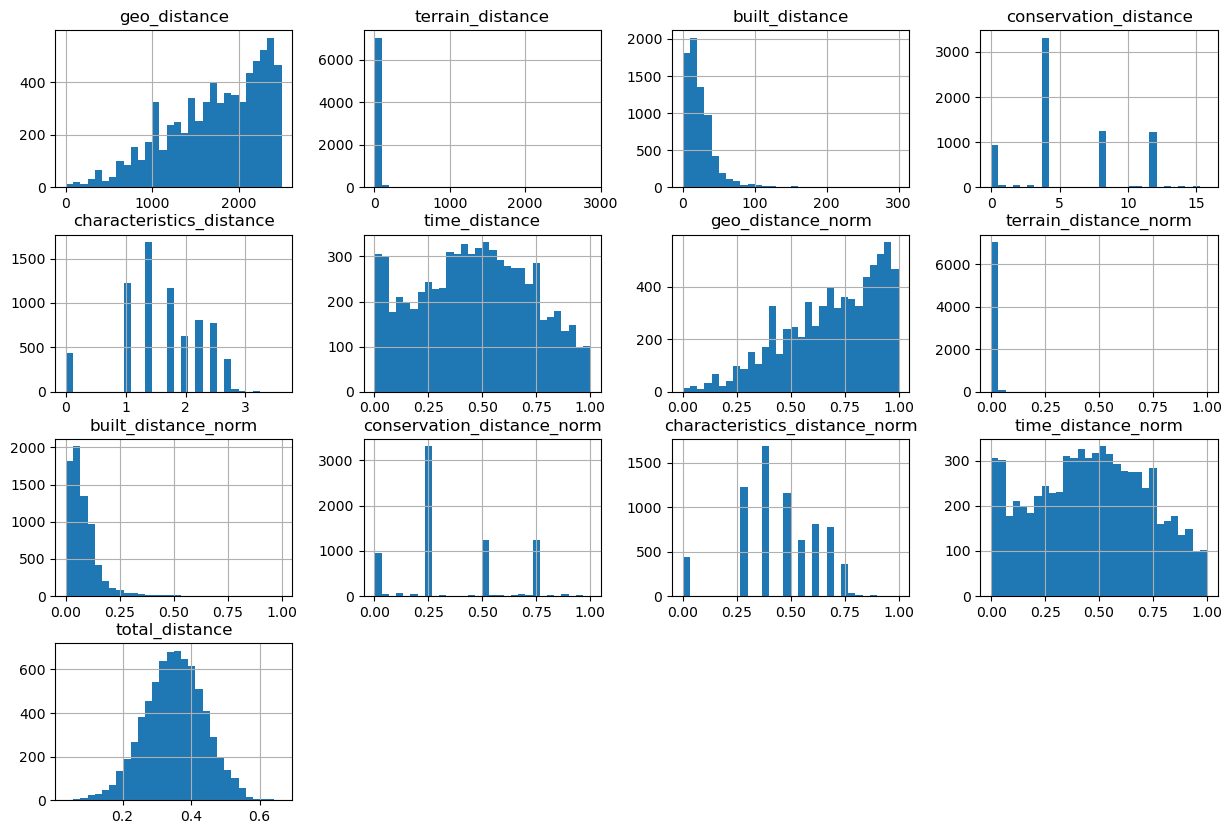

In [28]:
# see distribution of distances
gdf_neighbors_subset_distance.filter(like='distance').hist(bins=30, figsize=(15, 10))

In [42]:
# Step 1: Plot the main property
m = gdf_work_comps.loc[[idx_test], ['longitude', 'latitude', 'geometry']].explore(
    tiles="cartodbpositron",
    color="red",  # Use a distinct color for main property
    marker_kwds={'radius': 10},  # Adjust marker size if needed
    # tooltip="Main Property"  # Add a tooltip for easy identification
)

# Step 2: Add neighbors as a separate layer
neighbor_layer = (
    gdf_neighbors_subset_distance
    .assign(
        geometry=lambda x: gpd.points_from_xy(x['longitude_neighbor'], x['latitude_neighbor'])
    )
    .pipe(gpd.GeoDataFrame, crs="EPSG:6372")
    .loc[:, ['total_distance','geometry']]
    .explore(
        m=m,  # Add to the existing map
        color="blue",  # Different color for neighbors
        marker_kwds={'radius': 3},  # Adjust marker size if needed
        # tooltip="Competitor"
    )
)

# Display map
m

In [47]:
# Step 1: Plot the main property
m = gdf_work_comps.loc[[idx_test], ['longitude', 'latitude', 'geometry']].explore(
    tiles="cartodbpositron",
    color="red",  # Use a distinct color for main property
    marker_kwds={'radius': 20},  # Adjust marker size if needed
    # tooltip="Main Property"  # Add a tooltip for easy identification
)

# Step 2: Add neighbors as a separate layer
neighbor_layer = (
    gdf_neighbors_subset_distance
    .assign(
        geometry=lambda x: gpd.points_from_xy(x['longitude_neighbor'], x['latitude_neighbor'])
    )
    .pipe(gpd.GeoDataFrame, crs="EPSG:6372")
    .loc[:, ['total_distance','geometry']]
    .explore(
        'total_distance',
        m=m,  # Add to the existing map
        marker_kwds={'radius': 5},  # Adjust marker size if needed
        # tooltip="Competitor"
    )
)

# Display map
m

In [75]:
# top 10 props
# Step 1: Plot the main property
m = (
    gdf_neighbors_subset_distance
    .loc[[idx_test], ['longitude_own', 'latitude_own', 'observation_id_own', 'land_area_own', 'built_area_own', 'age_in_months_own', 'bedrooms_cat_own', 'full_bathrooms_cat_own', 'parking_lots_cat_own']]
    .assign(
        geometry=lambda x: gpd.points_from_xy(x['longitude_own'], x['latitude_own'])
    )
    .pipe(gpd.GeoDataFrame, crs="EPSG:6372")
    .merge(
        gdf_work_comps.loc[[idx_test], ['observation_id', 'price_per_sqm']],
        left_on='observation_id_own',
        right_on='observation_id'
    )
    .drop(columns=['longitude_own', 'latitude_own', 'observation_id_own', 'observation_id'])
    .explore(
        tiles="cartodbpositron",
        color="red",  # Use a distinct color for main property
        marker_kwds={'radius': 20},  # Adjust marker size if needed
    )
)

# Step 2: Add neighbors as a separate layer
neighbor_layer = (
    gdf_neighbors_subset_distance
    .merge(
        gdf_work_comps.loc[:, ['observation_id', 'price_per_sqm']],
        left_on='observation_id_neighbor',
        right_on='observation_id'
    )
    .assign(
        geometry=lambda x: gpd.points_from_xy(x['longitude_neighbor'], x['latitude_neighbor'])
    )
    .pipe(gpd.GeoDataFrame, crs="EPSG:6372")
    .loc[:, ['price_per_sqm', 'total_distance', 'geometry', 'longitude_neighbor', 'latitude_neighbor', 'observation_id_neighbor', 'land_area_neighbor', 'built_area_neighbor', 'age_in_months_neighbor', 'bedrooms_cat_neighbor', 'full_bathrooms_cat_neighbor', 'parking_lots_cat_neighbor']]
    .drop(columns=['longitude_neighbor', 'latitude_neighbor', 'observation_id_neighbor'])
    .sort_values('total_distance', ascending=True)
    .head(10)
    .explore(
        'price_per_sqm',
        m=m,  # Add to the existing map
        marker_kwds={'radius': 10},  # Adjust marker size if needed
        # tooltip="Competitor"
    )
)

# Display map
neighbor_layer

In [85]:
# get top 10 competitors
(
    gdf_neighbors_subset_distance
    .merge(
        gdf_work_comps.loc[:, ['observation_id', 'price_per_sqm']],
        left_on='observation_id_neighbor',
        right_on='observation_id'
    )
    .rename(columns={
        'price_per_sqm': 'price_per_sqm_neighbor',
        'total_distance': 'total_distance_neighbor',
    })
    .sort_values('total_distance_neighbor', ascending=True)
    .head(10)
    .filter(like='neighbor')
    # to all columns eliminate the suffix
    .rename(columns=lambda x: x.replace('_neighbor', ''))
)

id   index                        observation_id     longitude  \
6688  122320  122320  e1342be4-4baa-42c0-8480-ed0e9f158048  2.797615e+06   
288     3210    3210  e22a45c0-1e60-4fbe-83af-f4921d835eaf  2.796618e+06   
633     7174    7174  27f54be4-30e0-42fd-9fc4-913fba070300  2.797270e+06   
535     6051    6051  fbaa1fb3-e9dc-444e-a669-433d3b38f3b8  2.797603e+06   
704     7930    7930  4d7e132b-e5cd-445b-b563-25eb47cd0d28  2.797603e+06   
937    11161   11161  4ec44137-eff6-44ab-bd1b-3b3a6674b1c4  2.797302e+06   
67       636     636  852f595d-ce12-44fe-9dfd-f41b1a1bf9a0  2.797627e+06   
1086   12562   12562  05a1a22b-0f3c-4abd-a304-92fe08896036  2.798236e+06   
801     9251    9251  a540a1f8-9b87-4116-abd1-306197b62e95  2.796595e+06   
645     7293    7293  0897c261-5b46-43bc-89f4-dd78c04fb057  2.796867e+06   

           latitude  land_area  built_area  elevator_service_id_cat  \
6688  826994.500239  18.809999   97.250000                        0   
288   826494.954922  13.240000   90.160004                        0   
633   827279.646592  53.150002  121.739998                        0   
535   826192.157598  38.740002   88.519997                        0   
704   826202.144111  34.240002   88.519997                        0   
937   826195.833397  45.139999  104.500000                        0   
67    827061.405039  38.000000   87.470001                        0   
1086  825265.809215  32.130001   80.169998                        0   
801   826507.772015  19.450001  100.139999                        0   
645   826572.151523  19.900000   86.800003                        0   

      max_total_levels_recat  age_in_months  bedrooms_cat  full_bathrooms_cat  \
6688                       2              6             2                   2   
288                        2             36             2                   2   
633                        2             84             2                   2   
535                        2              0             2                   2   
704                        2              0             2                   2   
937                        2             36             2                   2   
67                         2             22             2                   2   
1086                       2             36             2                   2   
801                        2              3             2                   2   
645                        2              0             2                   2   

      parking_lots_cat valuation_date  total_distance  price_per_sqm  
6688                 2     2022-06-16        0.034963   44298.200514  
288                  2     2022-06-02        0.054299   57825.861139  
633                  2     2022-06-09        0.056782   63997.044001  
535                  2     2022-07-05        0.062726   65047.449371  
704                  2     2022-07-18        0.065736   58178.944818  
937                  2     2022-09-15        0.071396   59931.843529  
67                   2     2022-06-10        0.071854   50268.662840  
1086                 2     2022-07-08        0.073995   59423.725942  
801                  2     2022-05-04        0.075756   74465.748407  
645                  2     2022-04-29        0.076061   63894.044676

In [87]:
# see own
cols2see = [
    'observation_id', 'land_area', 'built_area', 'age_in_months', 'bedrooms_cat', 'full_bathrooms_cat', 'parking_lots_cat', 'valuation_date', 'price_per_sqm'
]

(
    gdf_work_comps
    .loc[[idx_test], cols2see]
)

observation_id  land_area  built_area  \
37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81  19.610001   77.510002   

    age_in_months  bedrooms_cat  full_bathrooms_cat  parking_lots_cat  \
37              4             2                   2                 2   

   valuation_date  price_per_sqm  
37     2022-06-14   67500.965757

In [22]:
# HERE!!! 
# NEXT STEP: BREAK find_competitors in 2: distance and aggregation
# SEE DISTANCES!!!

In [ ]:
# see
print(gdf_neighbors_subset.shape)
gdf_neighbors_subset

##### Programatically

In [ ]:
# # get possible neighbors by batch
# n_batches = gdf_work.shape[0] // batch_size
# if n_batches > 0:
#     batch_indexes = np.array_split(gdf_work.index, gdf_work.shape[0] // batch_size)
# else:
#     batch_indexes = [gdf_work.index]

# gdf_neighbors_list = []
# for batch in batch_indexes:
#     # print batch
#     # get possible neighbors
#     gdf_neighbors_info = get_possible_neighbors(
#         df_own=gdf_work.loc[batch],
#         df_theirs=gdf_work,
#         vars_list=cols_to_stay
#     )
#     # find competitors
#     gdf_neighbors_subset = find_competitors(gdf_neighbors_info)
#     # append
#     gdf_neighbors_list.append(gdf_neighbors_subset)

### Programatically

In [ ]:
# Get competitors
# city values
cities_list = gdf_properties['city_cluster'].sort_values().unique()
property_types_list = gdf_properties['property_type'].unique()

# params
GEO_WEIGHT = 0.1
TERRAIN_WEIGHT = 0.1
CONSERVATION_WEIGHT = 0.1
BUILT_WEIGHT = 0.2
CHAR_WEIGHT = 0.3
TIME_WEIGHT = 0.2

# calculate
df_competitors_list = []
for city in tqdm(cities_list, desc="Cities", position=0):
    for property_type in property_types_list:
        # get competitors
        df_comps = get_competitors(
            gdf_properties,
            property_type=property_type,
            city=city,
            batch_size=2_000,
            radius=2.5  # search radius in km
            )
        # append
        df_competitors_list.append(df_comps)
    
# concatenate
df_competitors = pd.concat(df_competitors_list)

## S2: Explore

In [ ]:
# see shape
df_competitors['num_neighbors'].describe()

In [ ]:
# see shape
df_competitors.shape

In [ ]:
# see shape vs original
gdf_properties.query("city_cluster.eq(0)").shape

In [ ]:
# see competitors with only 1
df_competitors.sort_values(by='num_neighbors', ascending=False)

In [ ]:
# expand and separate
vars_to_stay = [
    'property_id', 'property_type',
    'longitude', 'latitude',
    'land_area', 'built_area',
    'elevator_service_id_cat', 'max_total_levels_recat', 'remaining_useful_life_cat',
    'bedrooms_cat', 'full_bathrooms_cat', 'parking_lots_cat',
    'valuation_date', 'valor_mercado', 'precio_m2'
]

(
    df_competitors
    .query("observation_id_own.eq('5cc32435a1224836af921c93f0d8cb2a')")
    .explode('neighbors_list')
    .assign(
        observation_id_neighbor=lambda x: x['neighbors_list'].str[0],
        total_distance=lambda x: x['neighbors_list'].str[1],
    )
    .drop(columns=['neighbors_list'])
    .sort_values(by='total_distance', ignore_index=True)
    # merge info of property_own
    .merge(
        gdf_properties.loc[:, vars_to_stay],
        how='inner',
        left_on='observation_id_own',
        right_on='property_id',
        suffixes=('_own', '_neighbor'),
    )
    .drop(columns=['property_id'])
    # merge info of property_neighbor
    .merge(
        gdf_properties.loc[:, vars_to_stay],
        how='inner',
        left_on='observation_id_neighbor',
        right_on='property_id',
        suffixes=('_own', '_neighbor'),
    )
    # sort columns by name
    .sort_index(axis=1)
)

## S3: Create Sparse Matrix

In [ ]:
# create df that maps property_id with index
df_properties_map = (
    gdf_properties
    .loc[:, ['property_id']]
    .reset_index()
    .rename(columns={'index': 'property_index'})
)
df_properties_map

In [ ]:
# create function to map property_id to index
def create_sparse_matrix_in_batches(df, df_indexes, batch_size=1_000):
    """
    Convert a large DataFrame with property IDs and neighbor distances into a sparse matrix in batches.

    Parameters:
    df (pd.DataFrame): DataFrame with 'observation_id_own' and 'neighbors_list' columns.
                       'observation_id_own' contains item IDs.
                       'neighbors_list' contains lists of tuples (neighbor_id, distance).
    df_indexes (pd.DataFrame): DataFrame with 'property_id' and 'property_index' columns.
                                 'property_id' contains item IDs.
                                    'property_index' contains item indices.
    batch_size (int): The number of rows to process in each batch.

    Returns:
    scipy.sparse.csr_matrix: The resulting sparse matrix.
    """
    # Split DataFrame into approximately equal-sized batches
    num_batches = df.shape[0] // batch_size
    chunks = np.array_split(df, num_batches)

    # Initialize lists
    # info
    row_list = []
    col_list = []
    data_list = []

    # garantize the sparse matrix is square
    max_id = df_indexes['property_index'].max()

    for chunk in tqdm(chunks, desc="Batches"):
        # Expand chunk
        exploded_chunk = chunk.explode('neighbors_list').reset_index(drop=True)

        # Merge with index map
        exploded_chunk_ids = (
            exploded_chunk
            # property id
            .merge(df_indexes, left_on='observation_id_own', right_on='property_id')
            .loc[:, ['property_index', 'neighbors_list']]
            # neighbor id
            .assign(
                observation_id_neighbor=lambda x: x['neighbors_list'].str[0],
                total_distance=lambda x: x['neighbors_list'].str[1]
            )
            .merge(df_indexes, left_on='observation_id_neighbor', right_on='property_id', suffixes=('_own', '_neighbor'))
            .loc[:, ['property_index_own', 'property_index_neighbor', 'total_distance']]
        )

        # Extract row indices, column indices, and data values
        rows = exploded_chunk_ids['property_index_own'].values
        cols = exploded_chunk_ids['property_index_neighbor'].values
        distances = exploded_chunk_ids['total_distance'].values

        # Append to lists
        row_list.append(rows)
        col_list.append(cols)
        data_list.append(distances)

    # Concatenate all chunks
    rows = np.concatenate(row_list)
    cols = np.concatenate(col_list)
    distances = np.concatenate(data_list)

    # Create the sparse matrix, garanting it is square
    sparse_matrix = sp.csr_matrix((distances, (rows, cols)), shape=(max_id + 1, max_id + 1))

    return sparse_matrix

# Example usage
sparse_matrix_comps = create_sparse_matrix_in_batches(
    df=df_competitors,
    df_indexes=df_properties_map,
    batch_size=10_000
    )

print(sparse_matrix_comps.shape)

In [ ]:
# see shape
sparse_matrix_comps.shape

In [ ]:
# see how many non-zero elements
print(f"Non-zero elements: {sparse_matrix_comps.nnz}")
print(f"Sparsity: {sparse_matrix_comps.nnz / (sparse_matrix_comps.shape[0] * sparse_matrix_comps.shape[1])}")

In [ ]:
# how much memory it uses in MB
print(f"Memory usage: {sparse_matrix_comps.data.nbytes / 1e+6:.2f} MB")

## S4: Save

In [25]:
# save
dir_save = "../../data/misc"
os.makedirs(dir_save, exist_ok=True)

# save to pickle (in order to save lists, because parquet doesnt support lists)
df_competitors.to_pickle(f"{dir_save}/df_competitors.pkl")

In [26]:
# save sparse matrix
sp.save_npz(f"{dir_save}/sparse_matrix_competitors.npz", sparse_matrix_comps)

In [27]:
# save in matlab format
io.savemat(f"{dir_save}/sparse_matrix_competitors.mat", {"sparse_matrix_competitors": sparse_matrix_comps})

---
# Competitors Statistics

## S1: Define statistics

In [28]:
# summary statistics of competitors
def competitors_stats(df, col_to_summarize, xi=0.2):
    # get normalized weights
    weights_unorm = np.exp(-xi * df['total_distance'])
    weights = weights_unorm / weights_unorm.sum()
    n_neighbors = df.shape[0]
    sq_sum_weights = np.sum(weights**2) if n_neighbors > 1 else np.nan

    # get col to summarize
    x_array = df[col_to_summarize].values

    # weighted mean
    w_mean = np.sum(x_array * weights)

    return pd.Series({
        'weighted_mean': w_mean,
        'weighted_std': np.sqrt(
            # unbiased weighted std (theorem)
            (1 / (1 - sq_sum_weights)) * np.sum(weights * (x_array - w_mean)**2)
            ),
        'mean': np.mean(x_array),
        'std': np.std(x_array),
        'num_neighbors': n_neighbors,
    })


def get_info_from_competitors(df, df_info, col_to_summarize, xi=0.2, batch_size=2_000):
    # Split DataFrame into approximately equal-sized batches
    num_batches = df.shape[0] // batch_size
    chunks = np.array_split(df, num_batches)

    # Initialize list
    df_competitors_info_list = []

    for chunk in tqdm(chunks, desc="Batches"):
        # Expand chunk
        exploded_chunk = chunk.explode('neighbors_list').reset_index(drop=True)

        # Merge with info
        exploded_chunk = (
            exploded_chunk
            # neighbor id
            .assign(
                observation_id_neighbor=lambda x: x['neighbors_list'].str[0],
                total_distance=lambda x: x['neighbors_list'].str[1]
            )
            .merge(
                df_info.loc[:, ['property_id'] + [col_to_summarize]],
                left_on='observation_id_neighbor', right_on='property_id',
                suffixes=('_own', '_neighbor')
            )
            .drop(columns=['property_id', 'neighbors_list'])
        )

        # get stats
        df_competitors_info = (
            exploded_chunk
            .groupby('observation_id_own', as_index=False)
            .apply(
                competitors_stats,
                col_to_summarize=col_to_summarize,
                xi=xi,
                include_groups=False
                )
        )

        # append
        df_competitors_info_list.append(df_competitors_info)

    # concatenate
    df_competitors_info = pd.concat(df_competitors_info_list)

    return df_competitors_info

In [ ]:
# get info from competitors
df_competitors_info = get_info_from_competitors(
    df=df_competitors,
    df_info=gdf_properties,
    col_to_summarize='log_price_per_sqm',
    xi=5,
    batch_size=10_000
    )
df_competitors_info

In [ ]:
# rename
df_competitors_info = df_competitors_info.rename(columns={
    'weighted_mean': 'competitors_weighted_mean_log_price_per_sqm',
    'weighted_std': 'competitors_weighted_std_log_price_per_sqm',
    'mean': 'competitors_mean_log_price_per_sqm',
    'std': 'competitors_std_log_price_per_sqm',
    'num_neighbors': 'num_competitors',
})
df_competitors_info.head()

## S2: EDA

In [ ]:
# merge with original data
gdf_properties = (
    gdf_properties
    .merge(
        df_competitors_info,
        how='left',
        left_on='property_id',
        right_on='observation_id_own',
    )
    .drop(columns=['observation_id_own'])
)

# shape
gdf_properties.shape

In [ ]:
# see how many properties have competitors
gdf_properties['num_competitors'].describe()

In [ ]:
# see relationship between log_price_per_sqm and competitors_weighted_mean_log_price_per_sqm
fig, ax = plt.subplots(figsize=(6, 6))

(
    gdf_properties
    .query("num_competitors.ge(4)")
    .plot(
        x='log_price_per_sqm',
        y='competitors_weighted_mean_log_price_per_sqm',
        kind='scatter',
        ax=ax,
        alpha=0.1
    )
)

In [ ]:
# see relationship between log_price_per_sqm and competitors_weighted_mean_log_price_per_sqm
fig, ax = plt.subplots(figsize=(6, 6))

(
    gdf_properties
    .query("num_competitors.ge(4)")
    .plot(
        x='log_price_per_sqm',
        y='competitors_mean_log_price_per_sqm',
        kind='scatter',
        ax=ax,
        alpha=0.1
    )
)

In [ ]:
# see corr between log_price_per_sqm and competitors_weighted_mean_log_price_per_sqm and competitors_mean_log_price_per_sqm
(
    gdf_properties
    .query("num_competitors.ge(4)")
    .loc[:, ['log_price_per_sqm', 'competitors_weighted_mean_log_price_per_sqm', 'competitors_mean_log_price_per_sqm']]
    .corr(method='spearman')
)

## S3: Save

In [ ]:
# rename
df_competitors_info = df_competitors_info.rename(columns={
    'observation_id_own': 'property_id'
})
df_competitors_info.head()

In [37]:
# save
dir_save = "../../data/misc"
os.makedirs(dir_save, exist_ok=True)

# save to parquet
df_competitors_info.to_parquet(f"{dir_save}/df_competitors_stats.parquet")

---
# Save

In [ ]:
df_competitors_info.drop(columns='property_id').columns

In [39]:
# drop competitors columns
gdf_properties.drop(columns=df_competitors_info.drop(columns='property_id').columns, inplace=True)

# sort index
gdf_properties = gdf_properties.sort_index()

# save to parquet
gdf_properties.to_parquet("../../data/interim/cleaned_data_s6.parquet")

---
# Sandbox

In [60]:
gdf_neighbors_subset_distance

index_own                    observation_id_own  longitude_own  \
0            37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
1            37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
2            37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
3            37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
4            37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
...         ...                                   ...            ...   
9641         37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
9642         37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
9643         37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
9646         37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   
9647         37  f2537fb5-08d9-43b9-b9ab-6ad48cae5a81   2.797637e+06   

       latitude_own  land_area_own  built_area_own  \
0     826781.741007      19.610001       77.510002   
1     826781.741007      19.610001       77.510002   
2     826781.741007      19.610001       77.510002   
3     826781.741007      19.610001       77.510002   
4     826781.741007      19.610001       77.510002   
...             ...            ...             ...   
9641  826781.741007      19.610001       77.510002   
9642  826781.741007      19.610001       77.510002   
9643  826781.741007      19.610001       77.510002   
9646  826781.741007      19.610001       77.510002   
9647  826781.741007      19.610001       77.510002   

      elevator_service_id_cat_own  max_total_levels_recat_own  \
0                               0                           2   
1                               0                           2   
2                               0                           2   
3                               0                           2   
4                               0                           2   
...                           ...                         ...   
9641                            0                           2   
9642                            0                           2   
9643                            0                           2   
9646                            0                           2   
9647                            0                           2   

      age_in_months_own  bedrooms_cat_own  full_bathrooms_cat_own  \
0                     4                 2                       2   
1                     4                 2                       2   
2                     4                 2                       2   
3                     4                 2                       2   
4                     4                 2                       2   
...                 ...               ...                     ...   
9641                  4                 2                       2   
9642                  4                 2                       2   
9643                  4                 2                       2   
9646                  4                 2                       2   
9647                  4                 2                       2   

      parking_lots_cat_own valuation_date_own id_neighbor  index_neighbor  \
0                        2         2022-06-14           9               9   
1                        2         2022-06-14          12              12   
2                        2         2022-06-14          20              20   
3                        2         2022-06-14          21              21   
4                        2         2022-06-14          23              23   
...                    ...                ...         ...             ...   
9641                     2         2022-06-14      133158          133158   
9642                     2         2022-06-14      133159          133159   
9643                     2         2022-06-14      133259          133259   
9646                     2         2022-06-14      133285          133285   
9647                     2         

In [62]:
gdf_work_comps.filter(like='obs')

observation_id
0       6d3e7752-e54f-4c1e-b04b-06d67c4ef8c2
1       92612e5d-fd48-4fb6-bffe-b48885244330
2       87f302d3-fa35-417d-ba83-309911823476
3       0ee67491-ae3e-4095-95c2-e723e19da5b5
4       077a40b0-6cf0-4dbe-ade9-a6f232a2effa
...                                      ...
133291  2791d789-6f7a-46c0-856c-aad90796b82f
133292  6b8532e5-319d-4b58-90f3-8c656145fd54
133293  96b1bc4a-8c77-43cf-8328-3c9323f5268d
133294  215a1fce-1e4a-40df-90ac-bfce26fc3eb0
133295  e59c0988-c457-465f-8659-3be40e35ce58

[133296 rows x 1 columns]

In [ ]:
gdf_properties['age_in_months'].describe()

In [ ]:
gdf_properties.filter(like='area')

In [ ]:
# plot level vs total_levels, facet grid by property_type
g = sns.FacetGrid(gdf_properties, col="property_type_id", height=6)

g.map(
    sns.scatterplot,
    "level",
    "total_levels",
    alpha=1
)

In [ ]:
# histogram of max levels
gdf_properties[['level', 'total_levels']].max(axis=1).plot(kind='hist', bins=100)

In [ ]:
# histogram of max levels
gdf_properties[['level', 'total_levels']].max(axis=1)

In [25]:
# neighborhood that are similar to ROMA NORTE
mask = gdf_properties['neighborhood'].str.contains("ROMA NORTE", case=False, na=False)
gdf_properties[mask]

half_bathrooms  full_bathrooms property_class_more_common_in_area  \
267                  0               2                                  5   
1306                 0               1                                  5   
1524                 0               2                                  5   
1982                 0               2                                  4   
3079                 1               2                                  5   
...                ...             ...                                ...   
370292               0               2                                  5   
370409               0               2                                  4   
370410               0               3                                  4   
371797               0               3                                  5   
371798               1               3                                  5   

              neighborhood       constructor  zip_code  age_in_months  \
267             ROMA NORTE         NO APLICA      6700              4   
1306            ROMA NORTE  BANCO VE POR MAS      6700             12   
1524            ROMA NORTE         NO APLICA      6700             28   
1982            ROMA NORTE         NO APLICA      6700              0   
3079            ROMA NORTE         NO APLICA      6700            180   
...                    ...               ...       ...            ...   
370292  COLONIA ROMA NORTE         NO APLICA      6700              5   
370409          ROMA NORTE         NO APLICA      6700              0   
370410          ROMA NORTE         NO APLICA      6700              0   
371797          ROMA NORTE         NO APLICA      6700              0   
371798          ROMA NORTE         NO APLICA      6700              0   

        parking_lots valuation_date  potable_water_service_id  \
267                2     2022-06-14                       NaN   
1306               1     2022-05-11                       NaN   
1524               0     2022-08-09                       1.0   
1982               2     2022-06-13                       NaN   
3079               2     2022-05-05                       NaN   
...              ...            ...                       ...   
370292             1     2020-05-29                       1.0   
370409             2     2022-06-13                       NaN   
370410             2     2022-06-13                       NaN   
371797             2     2019-11-21                       1.0   
371798             2     2019-11-21                       1.0   

        lighting_service_id  sidewalk_id  project_quality_id  \
267                     NaN          NaN                 NaN   
1306                    NaN          NaN                 NaN   
1524                    2.0          1.0                 1.0   
1982                    NaN          NaN                 NaN   
3079                    NaN          NaN                 NaN   
...                     ...          ...                 ...   
370292                  2.0          1.0                 1.0   
370409                  NaN          NaN                 NaN   
370410                  NaN          NaN                 NaN   
371797                  2.0          1.0                 1.0   
371798                  2.0          1.0                 1.0   

        property_class_id  conservation_status_id  \
267                     5                       4   
1306                    5                       4   
1524                    5                       4   
1982                    4                       6   
3079                    5                       4   
...                   ...                     ...   
370292                  5                       5   
370409                  4                       6   
370410                  4                       6   
371797                  5                       6   
371798                  5                       6   

                   